# Higgs Classification

By Alexander Chkodrov  
November 11th, 2019 

In [1]:
import pickle
import math
import pandas as pd
import numpy as np
import scipy
from scipy import stats
import matplotlib.pyplot as plt

### Part 1: Expected Significance

The goal of this lab is to perform an inclusive search for the standard model Higgs boson in simulated LHC data, and use a set of training datasets to optimize event selections in order to enhance the discovery sensitivity. The optimal event selections will be applied to selected pseudo-experiment data. 

In [2]:
infile_qcd = open("qcd_100000_pt_1000_1200.pkl", 'rb')
qcd_dict = pickle.load(infile_qcd)

infile_higgs = open("higgs_100000_pt_1000_1200.pkl", 'rb')
higgs_dict = pickle.load(infile_higgs)

features = [key for key in qcd_dict.keys()]
print(features)

['pt', 'eta', 'phi', 'mass', 'ee2', 'ee3', 'd2', 'angularity', 't1', 't2', 't3', 't21', 't32', 'KtDeltaR']


According to the Standard Model, the Higgs field interacts with particles to give them mass. The Higgs boson is the associated quantum particle that interacts with the Higgs field, like an electron with an electric field. Based on this theoretical understanding that mass is a defining feature of the Higgs particle, we will use the mass of a jet as a feature to descriminate between those jets containing Higgs particles and those only containing a variety of other quantum chromodynamic (QCD) particles. The other features will be examined later.

It is worth noting that in this analysis the goal is to confirm the existance of the Higgs boson with maximum confidence. Direct observation of the Higgs is obscured by QCD noise, so instead observation of the parameters/features influenced by the presence of the Higgs boson will confirm its discovery.

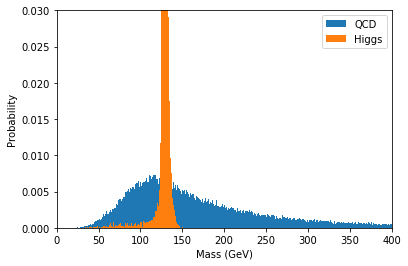

In [3]:
qcd_hist = plt.hist(qcd_dict.mass, density=True, bins=1000, label='QCD')
higgs_hist = plt.hist(higgs_dict.mass, density=True, bins=1000, label='Higgs')
plt.ylim(0,0.03)
plt.xlim(0,400)
plt.ylabel('Probability')
plt.xlabel('Mass (GeV)')
plt.legend()
plt.show()

This is a histogram of the QCD jet mass (blue) and the Higgs jet mass (orange). The histograms are by visual inspection very different, and so would make a good candidate for a descriminatory feature. Although the Higgs particles are about as massive as the average QCD particle, it has a far smaller standard deviation of masses and most commonly appears to have a mass of ~120-140 GeV.  

Lets assume the mass distributions for the QCD background and the Higgs signal are both Poisson with expected yields $N_{QCD} = 2000$ and $N_{Higgs} = 50$. Each distribution has a $\lambda = N$, where N is the given expected yield of the data set. If the null hypothesis suggests that there is no Higgs particle, then the expected background would be $N_{QCD}$ or 2000 particles. What is this significance of having recorded $N_{QCD} + N_{Higgs}$ particles?

In [4]:
Exp_higgs = 50
Exp_qcd = 2000
Exp_tot = Exp_qcd + Exp_higgs
theoretical_significance = stats.norm.isf(stats.poisson.sf(Exp_tot, Exp_qcd))
print('Significance: ', theoretical_significance)

Significance:  1.1282230087754423


For a poisson distribution with large $\lambda$, it can be approximated by a Gaussian distributed variable with mean $\lambda$ and standard deviation $\sqrt\lambda$.

Let $X$ be the sum of the two distributions with average $\lambda_{tot} = \lambda_{QCD}+\lambda_{Higgs}$, and therefore also poisson distributed. It can be approximated by a Gaussian distribution with average $\lambda_{QCD}+\lambda_{Higgs}$ and standard deviation $\sqrt{\lambda_{QCD}+\lambda_{Higgs}}$. Let $S$ be the significance. Using the Gaussian quantile function $\Phi^{-1}$, the inverse of the cumulative distribution function, we find an approximation for the expected significance 
$$S = \Phi^{-1}(1-p)$$
The p-value of the background only given an event $x$ is
$$p = 1 - \Phi({\frac{x-\mu}{\sigma}})$$
Where $\mu = \lambda_{QCD}$ and $\sigma = \sqrt{\lambda_{QCD}}$,
$$p = 1 - \Phi({\frac{x-\lambda_{QCD}}{\sqrt{\lambda_{QCD}}}})$$
Setting up for our equation for significance,
$$1-p = \Phi({\frac{x-\lambda_{QCD}}{\sqrt{\lambda_{QCD}}}})$$
$$\Phi^{-1}(1-p) = \frac{x-\lambda_{QCD}}{\sqrt{\lambda_{QCD}}}$$
Finally our value for significance,
$$S_x = \frac{x-\lambda_{QCD}}{\sqrt{\lambda_{QCD}}}$$
The average of X is $\lambda_{QCD}+\lambda_{Higgs}$
$$S_{avg} = \frac{\lambda_{Higgs}}{\sqrt{\lambda_{QCD}}}$$

By this formula, the average significance of the distribution X (the sum of the Higgs and QCD distributions) is $\frac{N_{Higgs}}{\sqrt{N_{QCD}}}$.

In [5]:
obs_significance = Exp_higgs/math.sqrt(Exp_qcd)
print('Significance: ', obs_significance)

Significance:  1.118033988749895


The difference between our significance calculation using Poisson statistics and the analytic formula we derived was almost negligible at ~0.01 sigma.  


### Part 2: Optimize Event Selection
Now, using our analytic formula, we find subsets of the data with the highest expected significance. First visualizing the data with a scatter plot,

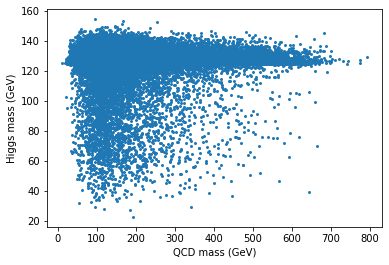

In [6]:
x = np.linspace(min(qcd_dict.mass), max(qcd_dict.mass), len(qcd_dict.mass))
plt.scatter(qcd_dict.mass, higgs_dict.mass, marker='.', linewidth=0.0001)
plt.xlabel('QCD mass (GeV)')
plt.ylabel('Higgs mass (GeV)')
plt.show()

There is visible seperation between the Higgs masses and QCD masses in the scatter plot above. It appears that a majority of the Higgs data would be included in the range of masses between 120 and 140 GeV, while excluding most of the QCD data -- we can double check and optimize this range using a random grid search, where very point in the Higgs data set becomes the corner of a cut and the expected significance is calculated using our above formula. The range resulting in the highest expected significance is recorded.

In [7]:
best_sig_gt = 0
best_sig_lt = 0
best_cut_mass = [0,0]
size = len(higgs_dict.mass)
for m in higgs_dict.mass:
    higgs_gt_m = len(higgs_dict.mass[higgs_dict.mass>m])
    qcd_gt_m = len(qcd_dict.mass[qcd_dict.mass>m])
    higgs_lt_m = size - higgs_gt_m
    qcd_lt_m = size-qcd_gt_m
    #Cut all less than m; find significance
    N_higgs = 50*higgs_gt_m/size
    N_qcd = 2000*qcd_gt_m/size
    expected_sig = N_higgs / math.sqrt(N_qcd)
    if(expected_sig > best_sig_gt):
        best_sig_gt = expected_sig
        best_cut_mass[0] = m
    #Cut all greater than m; find significance
    N_higgs = 50*higgs_lt_m/size
    N_qcd = 2000*qcd_lt_m/size
    expected_sig = N_higgs / math.sqrt(N_qcd)
    if(expected_sig > best_sig_lt):
        best_sig_lt = expected_sig
        best_cut_mass[1] = m
        
print(f'Best mass cut range: ({best_cut_mass[0]:.2f}, {best_cut_mass[1]:.2f})')

Best mass cut range: (122.45, 137.22)


In [8]:
higgs_mask = higgs_dict.mass.between(best_cut_mass[0],best_cut_mass[1])
qcd_mask = qcd_dict.mass.between(best_cut_mass[0],best_cut_mass[1])
N_higgs = 50*len(higgs_dict.mass[higgs_mask])/size
N_qcd = 2000*len(qcd_dict.mass[qcd_mask])/size
expected_sig = N_higgs / math.sqrt(N_qcd)
print(f'N_Higgs: {N_higgs:.0f}, N_QCD: {N_qcd:.0f}')
print('Higgs jets: ', len(higgs_dict.mass[higgs_mask]))
print('QCD jets: ',len(qcd_dict.mass[qcd_mask]))
print(f'Expected significance in best mass cut range: {expected_sig:.2f}')
print(f'Probability of observation given null hypothesis: {stats.norm.sf(expected_sig)}')

N_Higgs: 47, N_QCD: 187
Higgs jets:  93233
QCD jets:  9334
Expected significance in best mass cut range: 3.41
Probability of observation given null hypothesis: 0.0003226102533907361


Using a random grid search starting from either side of the mass distribution, we find cutting all mass data outside the range 122.5 to 137.2 maximizes expected significance using the formula $S = \frac{N_{Higgs}}{\sqrt{N_{QCD}}}$. The range contains the maximum signal-to-noise ratio in this dataset. If the null hypothesis that no Higgs particles exist is true, the expected significance of this measurement would be 3.41 sigma, or in other words it would have a 1/3000 chance of happening.

Besides mass, there are many other descriminating features that can differentiate between a Higgs particle and a QCD particle. Stacked histograms for the rest of the features are below, with the Higgs data set in orange and the QCD background in blue. This is without any event selection or cuts.

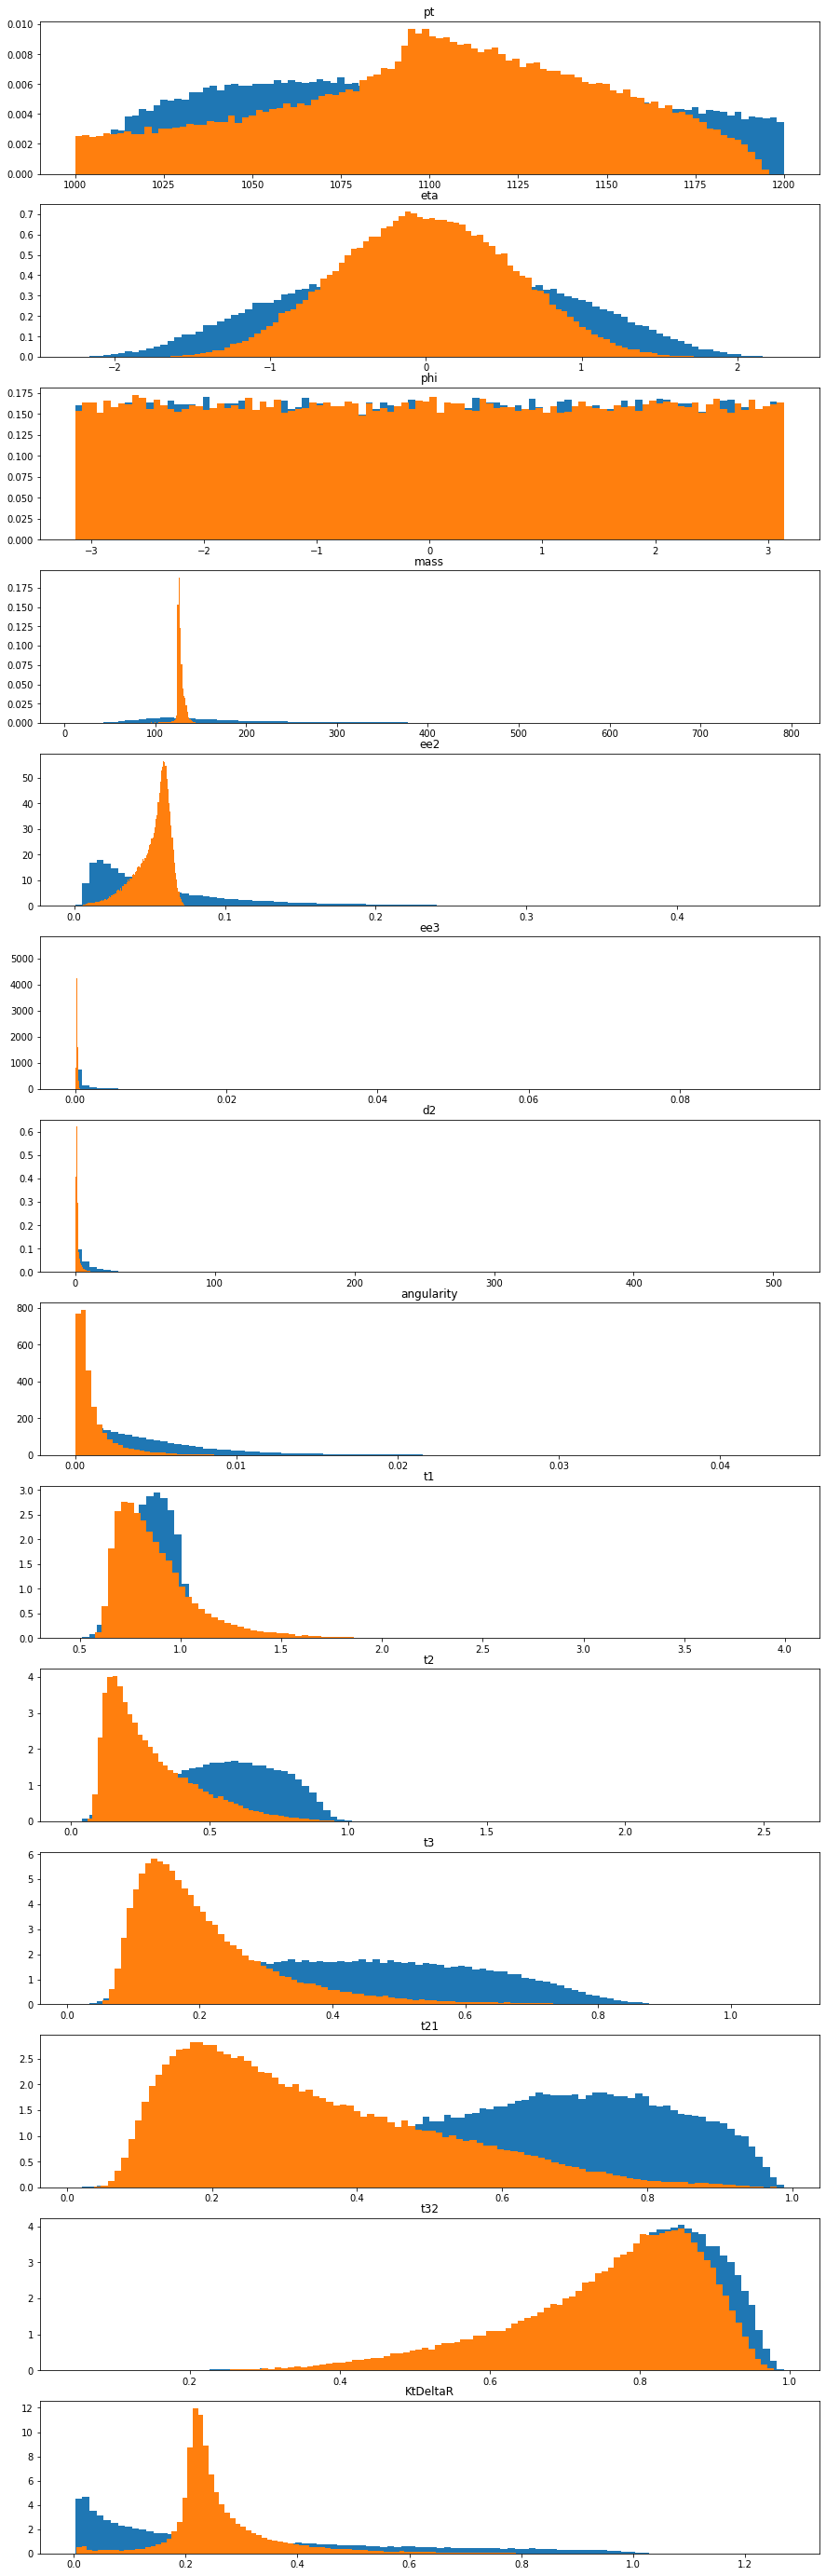

In [9]:
fig, ax_arr = plt.subplots(len(qcd_dict.keys()),1, figsize=(15,50))
index = 0
for key in qcd_dict.keys():
    ax_arr[index].hist(qcd_dict.get(key), bins=100, density=True)
    ax_arr[index].title.set_text(key)
    ax_arr[index].hist(higgs_dict.get(key), bins=100, density=True)
    ax_arr[index].title.set_text(key)
    index += 1

Now, with our optimal mass cuts reducing the data set and plotted again,

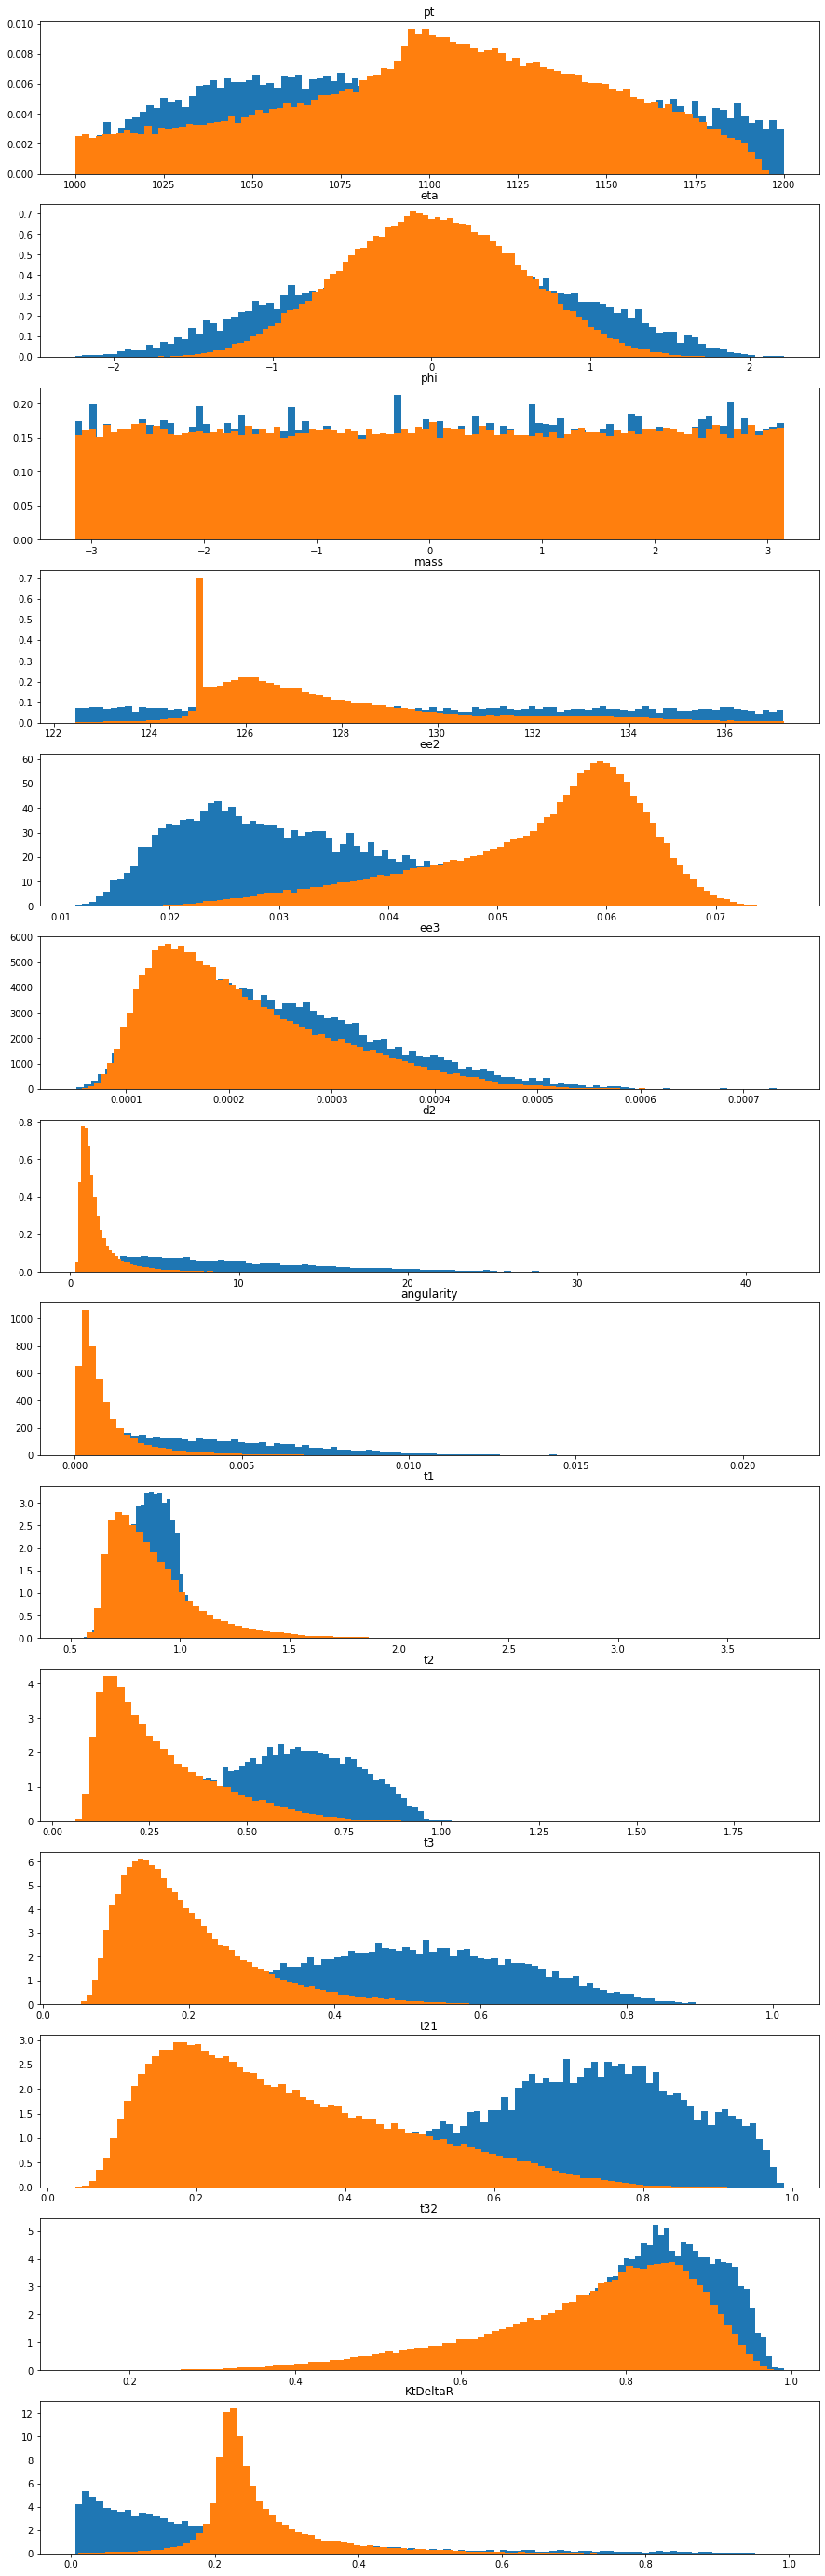

In [10]:
higgs_cut = higgs_dict[higgs_dict.mass.between(best_cut_mass[0],best_cut_mass[1])]
qcd_cut = qcd_dict[qcd_dict.mass.between(best_cut_mass[0],best_cut_mass[1])]
fig, ax_arr = plt.subplots(len(qcd_cut.keys()),1, figsize=(15,50))
index = 0
for key in qcd_dict.keys():
    ax_arr[index].hist(qcd_cut.get(key), bins=100, density=True)
    ax_arr[index].title.set_text(key)
    ax_arr[index].hist(higgs_cut.get(key), bins=100, density=True)
    ax_arr[index].title.set_text(key)
    index += 1

By visual inspection, the features ee2 and d2 and ktDeltaR provide good descriminatory power. The mass histogram for both datasets has changed significantly after our mass cut.

In [11]:
corr_table = qcd_dict.corr()
a = (corr_table-np.eye(len(corr_table))).max()
b = (corr_table-np.eye(len(corr_table))).idxmax()
pd.DataFrame([a,b]).T

,0,1
pt,0.0954613,mass
eta,0.00178366,phi
phi,0.00284771,t32
mass,0.959965,ee2
ee2,0.959965,mass
ee3,0.844699,ee2
d2,0.622112,t3
angularity,0.529638,mass
t1,0.326725,t2
t2,0.93664,t3


The features ee2 and mass are highly correlated; d2 and KtDeltaR are more independant. Arbitrarily selcting d2 for the next feature to analyze. Finding the optimal cuts for d2 using a random grid search,

In [12]:
best_sig_gt = 0
best_sig_lt = 0
best_cut_d2 = [0,0]
size = len(higgs_dict.d2)
for d in higgs_cut.d2:
    higgs_gt_d = len(higgs_dict.d2[higgs_dict.d2>d])
    qcd_gt_d = len(qcd_dict.d2[qcd_dict.d2>d])
    higgs_lt_d = size - higgs_gt_d
    qcd_lt_d = size-qcd_gt_d
    #Cut all less than d; find significance
    N_higgs = 50*higgs_gt_d/size
    N_qcd = 2000*qcd_gt_d/size
    expected_sig = N_higgs / math.sqrt(N_qcd)
    if(expected_sig > best_sig_gt):
        best_sig_gt = expected_sig
        best_cut_d2[0] = d
    #Cut all greater than d; find significance
    N_higgs = 50*higgs_lt_d/size
    N_qcd = 2000*qcd_lt_d/size
    expected_sig = N_higgs / math.sqrt(N_qcd)
    if(expected_sig > best_sig_lt):
        best_sig_lt = expected_sig
        best_cut_d2[1] = d
        
print(f'Best d2 cut range: ({best_cut_d2[0]:.2f}, {best_cut_d2[1]:.2f})')

Best d2 cut range: (0.36, 1.42)


In [13]:
higgs_mask = higgs_dict.d2.between(best_cut_d2[0],best_cut_d2[1]) & higgs_dict.mass.between(best_cut_mass[0], best_cut_mass[1])
qcd_mask = qcd_dict.d2.between(best_cut_d2[0],best_cut_d2[1]) & qcd_dict.mass.between(best_cut_mass[0], best_cut_mass[1])
N_higgs = 50*len(higgs_dict.mass[higgs_mask])/size
N_qcd = 2000*len(qcd_dict.mass[qcd_mask])/size
expected_sig = N_higgs / math.sqrt(N_qcd)
#expected_sig = stats.norm.isf(stats.poisson.sf(N_higgs+N_qcd, N_qcd))
print(f'N_Higgs: {N_higgs:.0f}, N_QCD: {N_qcd:.0f}')
print('Higgs jets: ', len(higgs_dict.mass[higgs_mask]))
print('QCD jets: ',len(qcd_dict.mass[qcd_mask]))
print(f'Expected significance in best mass, d2 cut range: {expected_sig:.2f}')
print(f'Probability of observation given null hypothesis: {stats.norm.sf(expected_sig)}')

N_Higgs: 28, N_QCD: 1
Higgs jets:  56130
QCD jets:  59
Expected significance in best mass, d2 cut range: 25.84
Probability of observation given null hypothesis: 1.7511252360831353e-147


In the above example, the optimal cuts for d2 were found seperately from the optimal cuts for mass. The result might be different if the d2 cuts were found using the already cut data set, however using the original data set gives more reliable cuts. When using both mass and d2 cuts for event selection, the expected significance reaches 26 sigma using our analytical formula $S = \frac{N_{Higgs}}{\sqrt{N_{QCD}}}$. If our null hypothesis was true that no Higgs particles existed, this observation of 29 particles in this range with an expected count of 1 would have a significance of 26 sigma, or a one in 4.0e+148 chance using our analytical formula; using actual poisson statistics, it is nearer to 1.0e-30, however with such small sample sizes it seems more fitting to use the analytical formula, as the accuracy was already established when looking at the entire data set.

Below are the histograms of the Higgs and QCD data sets after our optimal mass and d2 cuts. There are only ~60 data points comprising the QCD background with these optimal cuts, so the QCD histograms are sparse and unreliable.

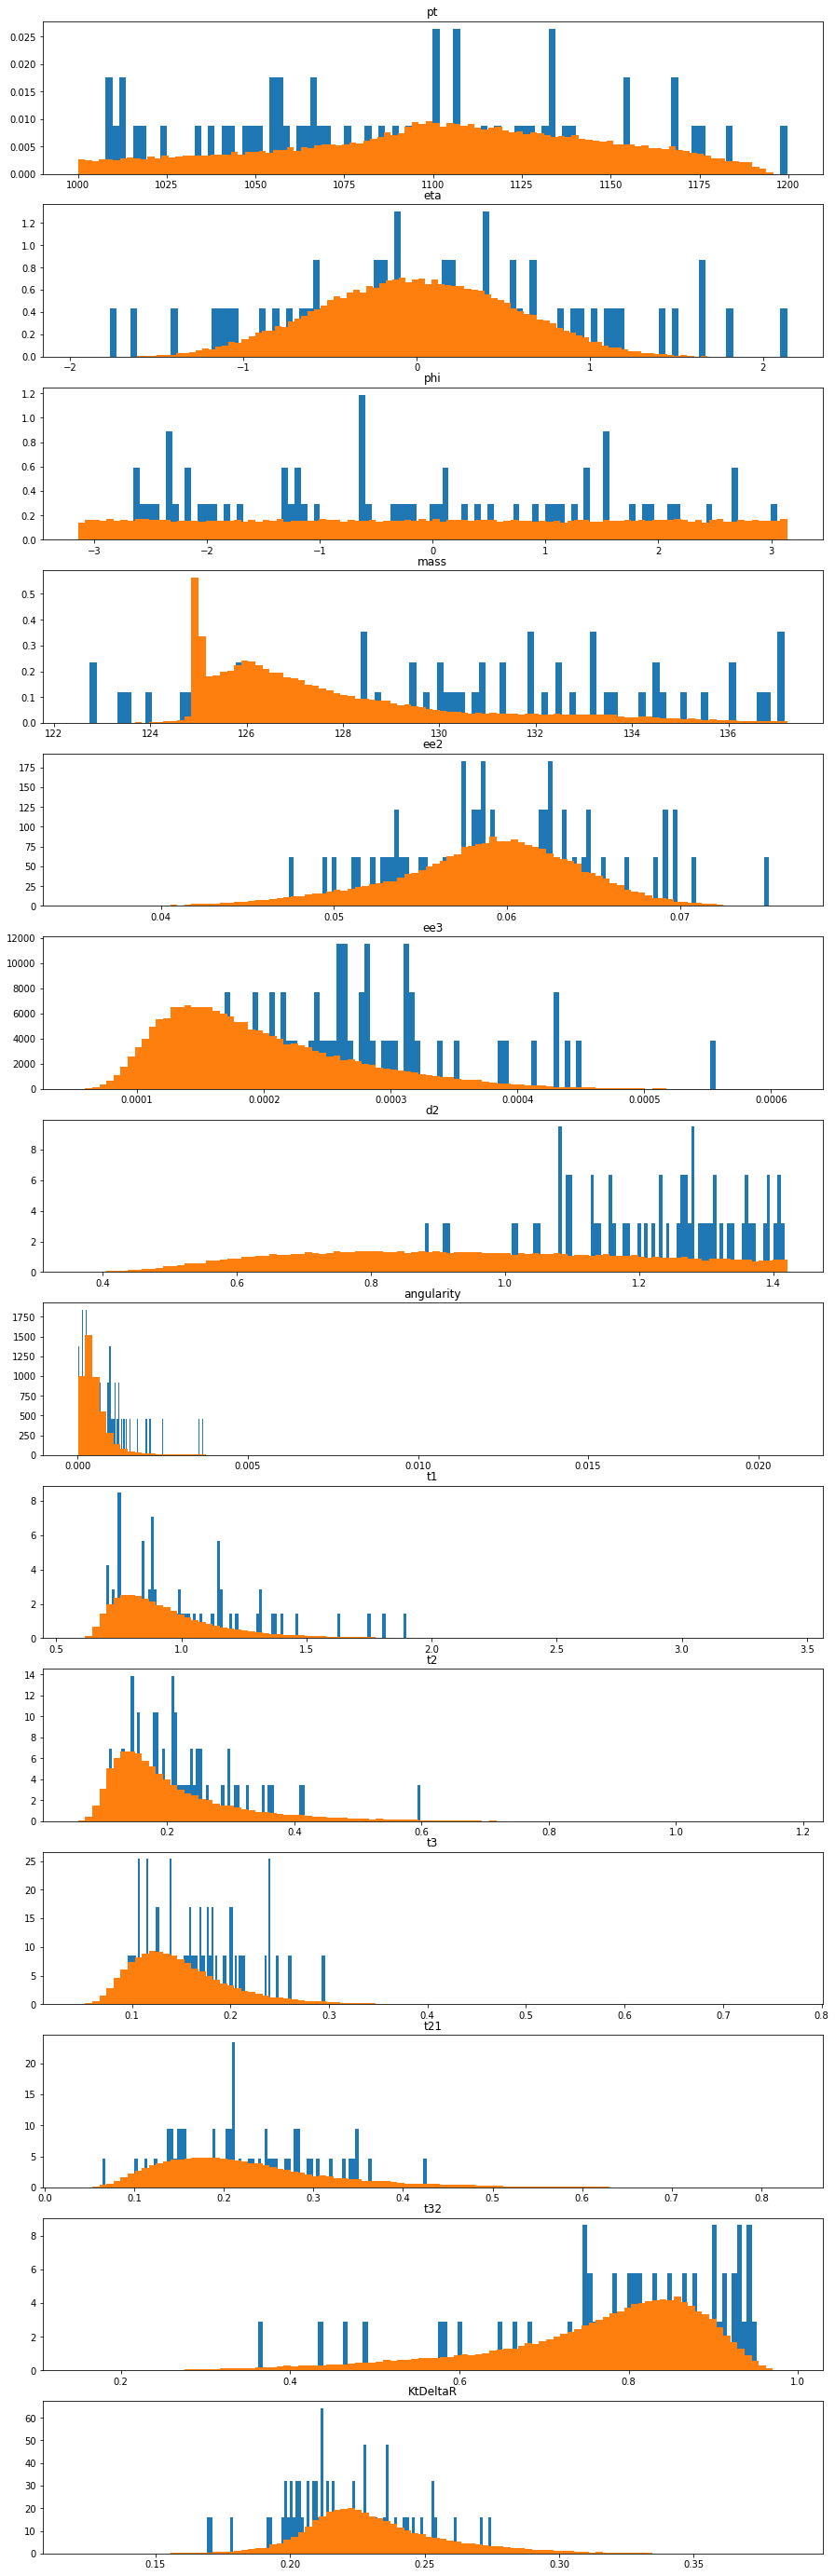

In [14]:
higgs_cut = higgs_dict[higgs_mask]
qcd_cut = qcd_dict[qcd_mask]
fig, ax_arr = plt.subplots(len(qcd_cut.keys()),1, figsize=(15,50))
index = 0
for key in qcd_dict.keys():
    ax_arr[index].hist(qcd_cut.get(key), bins=100, density=True)
    ax_arr[index].title.set_text(key)
    ax_arr[index].hist(higgs_cut.get(key), bins=100, density=True)
    ax_arr[index].title.set_text(key)
    index += 1

The important takeaway from this plot is the transformation which occured to the mass and d2 histograms due to the mass and d2 cuts. Below, the cut region is visualized with scatterplots of the mass and d2 features for both the Higgs data set and the QCD data set.

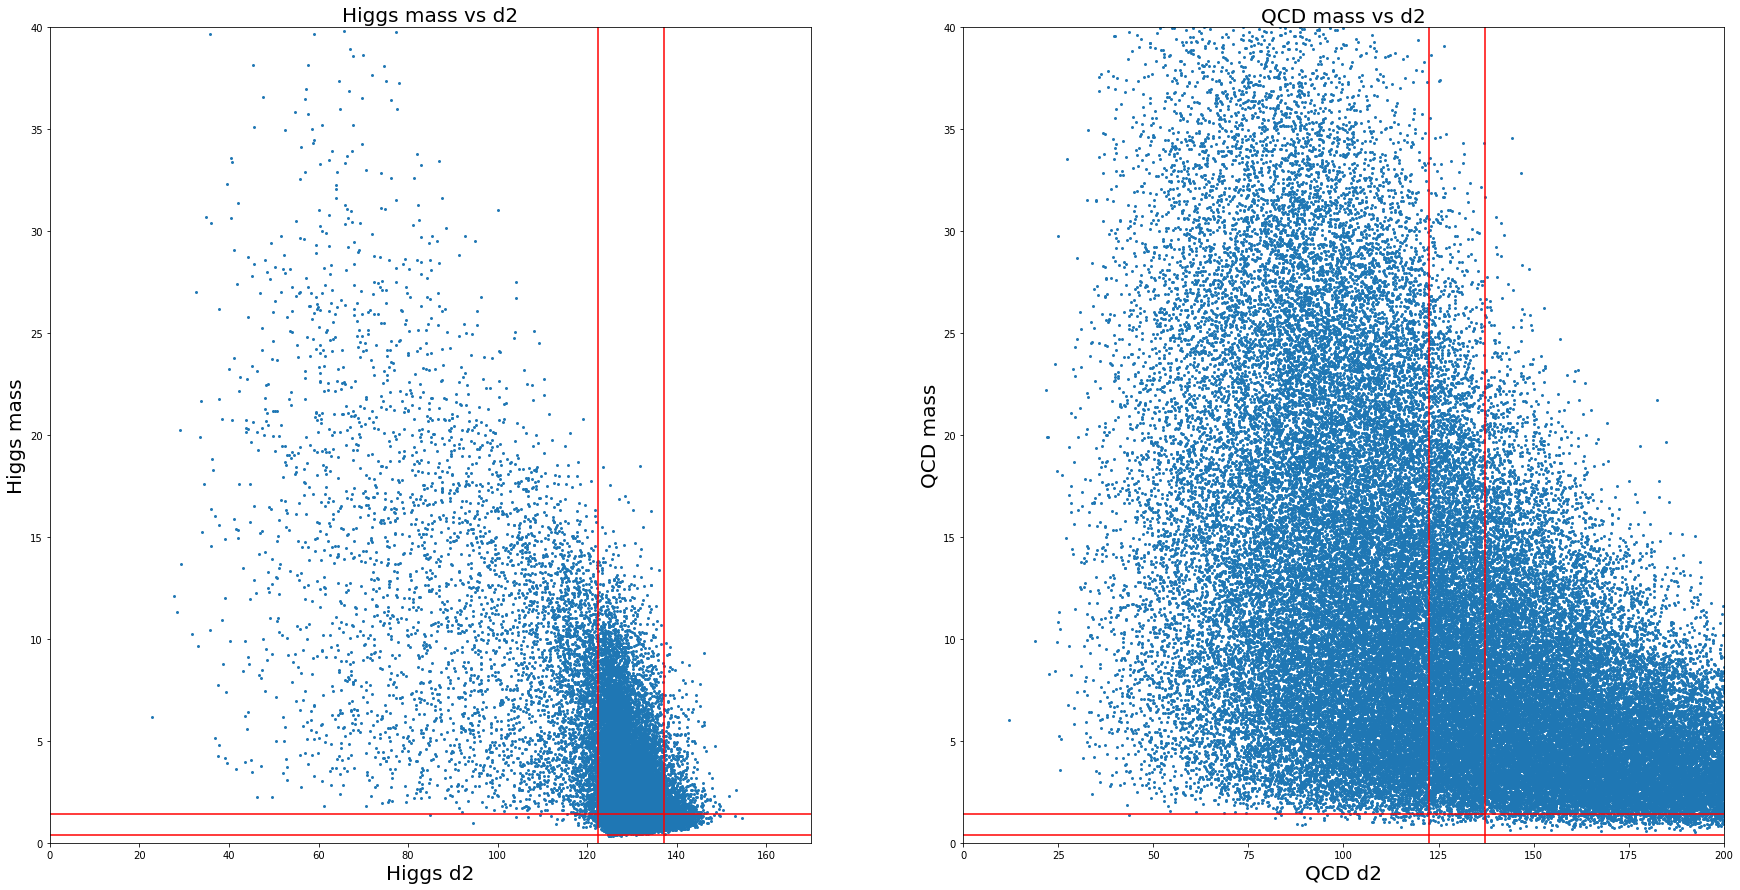

In [15]:
fig, ax = plt.subplots(1,2,figsize=(30,15))
ax[0].scatter(higgs_dict.mass, higgs_dict.d2, marker='.', linewidth=0.0001)
x = np.linspace(min(qcd_dict.mass), max(qcd_dict.mass), len(qcd_dict.mass))
ax[0].vlines(best_cut_mass[0],0,150, colors='r')
ax[0].vlines(best_cut_mass[1],0,150, colors='r')
ax[0].hlines(best_cut_d2[0],0,700, colors='r')
ax[0].hlines(best_cut_d2[1],0,700, colors='r')
ax[0].set_xlim(0,170)
ax[0].set_ylim(0, 40)
ax[0].set_title('Higgs mass vs d2', size=20)
ax[0].set_ylabel('Higgs mass', fontsize=20)
ax[0].set_xlabel('Higgs d2', fontsize=20)
x = np.linspace(min(higgs_dict.mass), max(higgs_dict.mass), len(higgs_dict.mass))
ax[1].scatter(qcd_dict.mass, qcd_dict.d2, marker='.', linewidth=0.0001)
ax[1].vlines(best_cut_mass[0],0,50, colors='r')
ax[1].vlines(best_cut_mass[1],0,50, colors='r')
ax[1].hlines(best_cut_d2[0],0,200, colors='r')
ax[1].hlines(best_cut_d2[1],0,200, colors='r')
ax[1].set_xlim(0,200)
ax[1].set_ylim(0,40)
ax[1].set_title('QCD mass vs d2', size=20)
ax[1].set_ylabel('QCD mass', fontsize=20)
ax[1].set_xlabel('QCD d2', fontsize=20)
plt.show()

The red lines represent the cuts on mass and d2. The Higgs dataset has a large subset enclosed by the cuts, while the QCD background is mostly excluded. The area enclosed by these cuts contains the maximum signal to noise ratio of these two features.  

A different approach to descriminating between Higgs and QCD events is to create a classifier to discern whether an event comes from the Higgs data set or the QCD data set. It will use the two features we've selected, mass and d2.

In [16]:
from sklearn import svm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
#from sklearn.model_selection import cross_val_score

X = higgs_dict.append(qcd_dict)
y = np.append(np.ones((len(higgs_dict),1), dtype=int),
              np.zeros((len(qcd_dict),1),dtype=int))

In [17]:
#Using only two features, mass and d2 (the same as analyzed above)
X_new = np.array([X.mass, X.d2]).T

In [18]:
#X_scaled = preprocessing.StandardScaler().fit_transform(X_new)
X_train, X_test, y_train, y_test = train_test_split(X_new,y, test_size=0.6)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [19]:
clf = svm.SVC(kernel='poly', degree=3, gamma='scale', probability=True)
clf.fit(X_train_scaled,y_train)
clf.score(X_test_scaled, y_test)

0.888

Using only the features mass and d2, a support vector classifier with a polynomial kernel of degree 3 is trained on a randomly shuffled 80% of the 200k events (100k Higgs and 100k QCD). With only two features this classifier achieves ~89% accuracy at determining whether or not a given event comes from the higgs data set or the QCD data set. This could be increased using additional features, at the cost of computational complexity.

Below is a plot of the classification boundaries. The first plot is the probability of classification as a higgs event (in blue/purple) vs classification as a QCD event (yellow) based on the two features mass and d2 by the polynomial support vector classifier. To the right is a scatterplot of Higgs and QCD mass vs d2, with the Higgs events in brown and the QCD events in light blue.

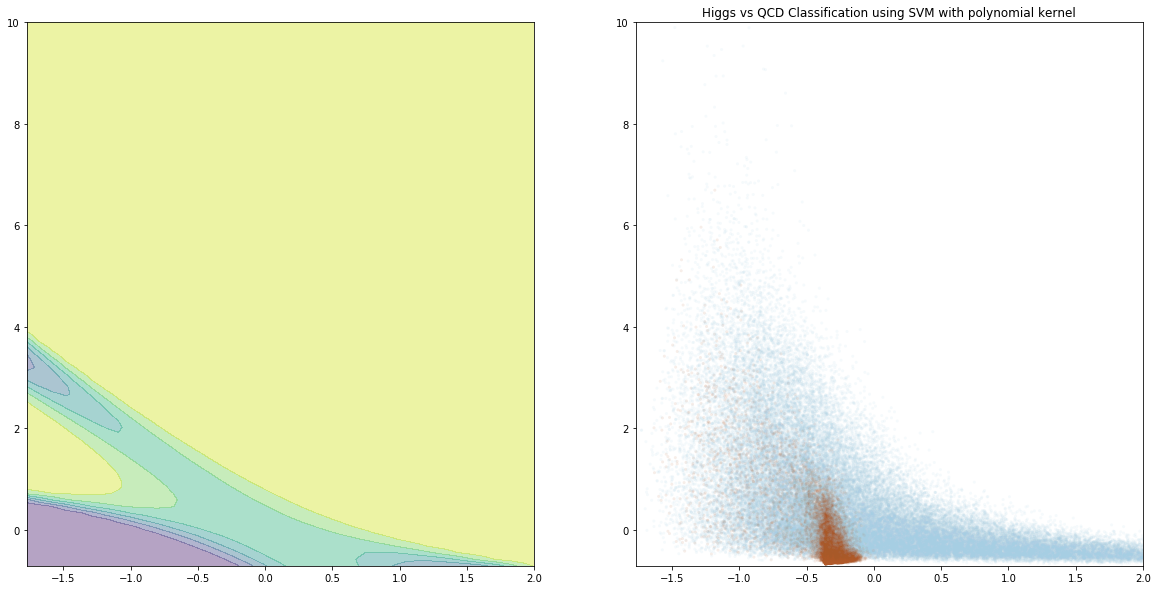

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))

x_min = min(X_test_scaled[:,0])
x_max = max(X_test_scaled[:,0])
y_min = min(X_test_scaled[:,1])
y_max = max(X_test_scaled[:,1])
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100).T)
XX = np.c_[xx.ravel(), yy.ravel()]
Z = clf.predict_proba(XX)[:,0].reshape(xx.shape)

# Put the result into a color plot
ax[0].contourf(xx, yy, Z, alpha=0.4)
ax[1].scatter(X_test_scaled[:,0], X_test_scaled[:,1], c=y_test, cmap=plt.cm.Paired,
            edgecolors='k', marker='.', linewidths=0.000001, alpha=0.1)
plt.title('Higgs vs QCD Classification using SVM with polynomial kernel')
plt.axis('tight')

ax[0].set_xlim(x_min, 2)
ax[0].set_ylim(y_min, 10)
ax[1].set_xlim(x_min, 2)
ax[1].set_ylim(y_min, 10)

plt.show()

In [21]:
Higgs_scaled = scaler.transform(np.array([higgs_dict.mass, higgs_dict.d2]).T)
y_higgs_pred = clf.predict(Higgs_scaled)
Higgs_events = sum(y_higgs_pred)
print(f"Higgs jets: {Higgs_events:.0f}")
qcd_scaled = scaler.transform(np.array([qcd_dict.mass, qcd_dict.d2]).T)
y_qcd_pred = clf.predict(qcd_scaled)
QCD_events = sum(y_qcd_pred) #Number of QCD events included after classification
print(f"QCD jets:   {QCD_events:.0f}")
y_pred = np.concatenate((y_higgs_pred, y_qcd_pred), axis=0)
F1_score = f1_score(y, y_pred)
print(f"Classifier F1 score: {F1_score:.3f}")
N_higgs = 50*Higgs_events/100000
N_qcd = 2000*QCD_events/100000
expected_sig = N_higgs / math.sqrt(N_qcd)
print(f'N_Higgs: {N_higgs:.0f}, N_QCD: {N_qcd:.0f}')
print(f'Expected significance: {expected_sig:.2f}')
print(f'Probability of observation given null hypothesis: {stats.norm.sf(expected_sig)}')

Higgs jets: 84298
QCD jets:   6422
Classifier F1 score: 0.884
N_Higgs: 42, N_QCD: 128
Expected significance: 3.72
Probability of observation given null hypothesis: 9.99694168072694e-05


The classifier has an F1 score of around .9, and performs slightly better than our mass cut alone for selecting data to compute significance from. However, the classifier did train using two features, and our two-feature cut had a much greater performance than this classifier when it comes to maximizing expected significance.

Now to train a classifier using all 14 features,

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.7)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_scaled = preprocessing.StandardScaler().fit_transform(X)

In [23]:
clf = svm.SVC(kernel='poly', degree=3, gamma='scale', probability=True)
clf.fit(X_train_scaled,y_train)
clf.score(X_test_scaled, y_test)

0.9382642857142857

In [24]:
Higgs_scaled = scaler.transform(higgs_dict)
y_higgs_pred = clf.predict(Higgs_scaled)
Higgs_events = sum(y_higgs_pred)
print(f"Higgs jets: {Higgs_events:.0f}")

qcd_scaled = scaler.transform(qcd_dict)
y_qcd_pred = clf.predict(qcd_scaled)
QCD_events = sum(y_qcd_pred) #Number of QCD events included after classifier
print(f"QCD jets:   {QCD_events:.0f}")

y_pred = np.concatenate((y_higgs_pred, y_qcd_pred), axis=0)
F1_score = f1_score(y, y_pred)
print(f"Classifier F1 score: {F1_score:.3f}")
N_higgs = 50*Higgs_events/100000
N_qcd = 2000*QCD_events/100000
expected_sig = N_higgs / math.sqrt(N_qcd)
print(f'N_Higgs: {N_higgs:.0f}, N_QCD: {N_qcd:.0f}')
print(f'Expected significance: {expected_sig:.2f}')
print(f'Probability of observation given null hypothesis: {stats.norm.sf(expected_sig)}')

Higgs jets: 94121
QCD jets:   6378
Classifier F1 score: 0.939
N_Higgs: 47, N_QCD: 128
Expected significance: 4.17
Probability of observation given null hypothesis: 1.54474566403043e-05


The classifier with 14 features performs slightly better than the classifier with 2 features, with an F1 score of 0.94 and an expected significance of 4 sigma.

Now, using the classifier and the cuts,

In [25]:
size = len(y)/2
higgs_new = higgs_dict[y_pred[:100000] == 1]
qcd_new = qcd_dict[y_pred[100000:] == 1]
higgs_mask = higgs_new.d2.between(best_cut_d2[0],best_cut_d2[1]) & higgs_new.mass.between(best_cut_mass[0], best_cut_mass[1])
qcd_mask = qcd_new.d2.between(best_cut_d2[0],best_cut_d2[1]) & qcd_new.mass.between(best_cut_mass[0], best_cut_mass[1])
N_higgs = 50*len(higgs_new.mass[higgs_mask])/size
N_qcd = 2000*len(qcd_new.mass[qcd_mask])/size
expected_sig = N_higgs / math.sqrt(N_qcd)
print(f'Expected significance: {expected_sig:.2f}')
print('Higgs events: ', len(higgs_new.mass[higgs_mask]))
print('QCD events: ',len(qcd_new.mass[qcd_mask]))
one = np.ones((len(higgs_new.mass[higgs_mask]), 1))
two = np.zeros((200000-len(higgs_new.mass[higgs_mask])-len(qcd_new.mass[qcd_mask])))
three = np.ones((len(qcd_new.mass[qcd_mask]),1))
y_combined = np.concatenate([one.squeeze(),two.squeeze(),three.squeeze()])
f1 = f1_score(y, y_combined)
print(f'F1 score of classifier + data cuts: {f1:.2f}')

Expected significance: 25.82
Higgs events:  56091
QCD events:  59
F1 score of classifier + data cuts: 0.72


The classifier plus data cuts provides a massive increase in expected significance, however greatly decreases the f1 score which accounts for true negatives and false positives. The data cuts are very effective for maximizing signal to noise ratio, however the true negative rate makes it unusable for classifying experimental data.

Out of these three methods, the classifier followed by data cuts had the best performance for optimizing expected significance, at the cost of a nearly 50% true negative rate and large computational complexity. Alternatively, only using the data cuts had a marginally lower expected significance and minimal computation time. Going into the experimental data analysis, the data cut method alone will be used.

### Part 3: Experimental Data Analysis
#### 3.1: High Luminosity Data

In [26]:
high = pd.read_hdf('data_highLumi_pt_1000_1200.h5')
print(f'Total experiment events: {len(high.mass)}')

Total experiment events: 4066


In [27]:
N_higgs = len(high.mass)/len(higgs_dict.mass)*Exp_higgs
N_qcd = len(high.mass)/len(qcd_dict.mass)*Exp_qcd
print(f'N_Higgs scaled: {N_higgs:.0f}')
print(f'N_QCD scaled: {N_qcd:.0f}')

N_Higgs scaled: 2
N_QCD scaled: 81


Scaling the expected number of Higgs and QCD particles from 100k events to 4k yields an expected $N_{Higgs}=2$ and $N_{QCD}=81$ without any event selection.

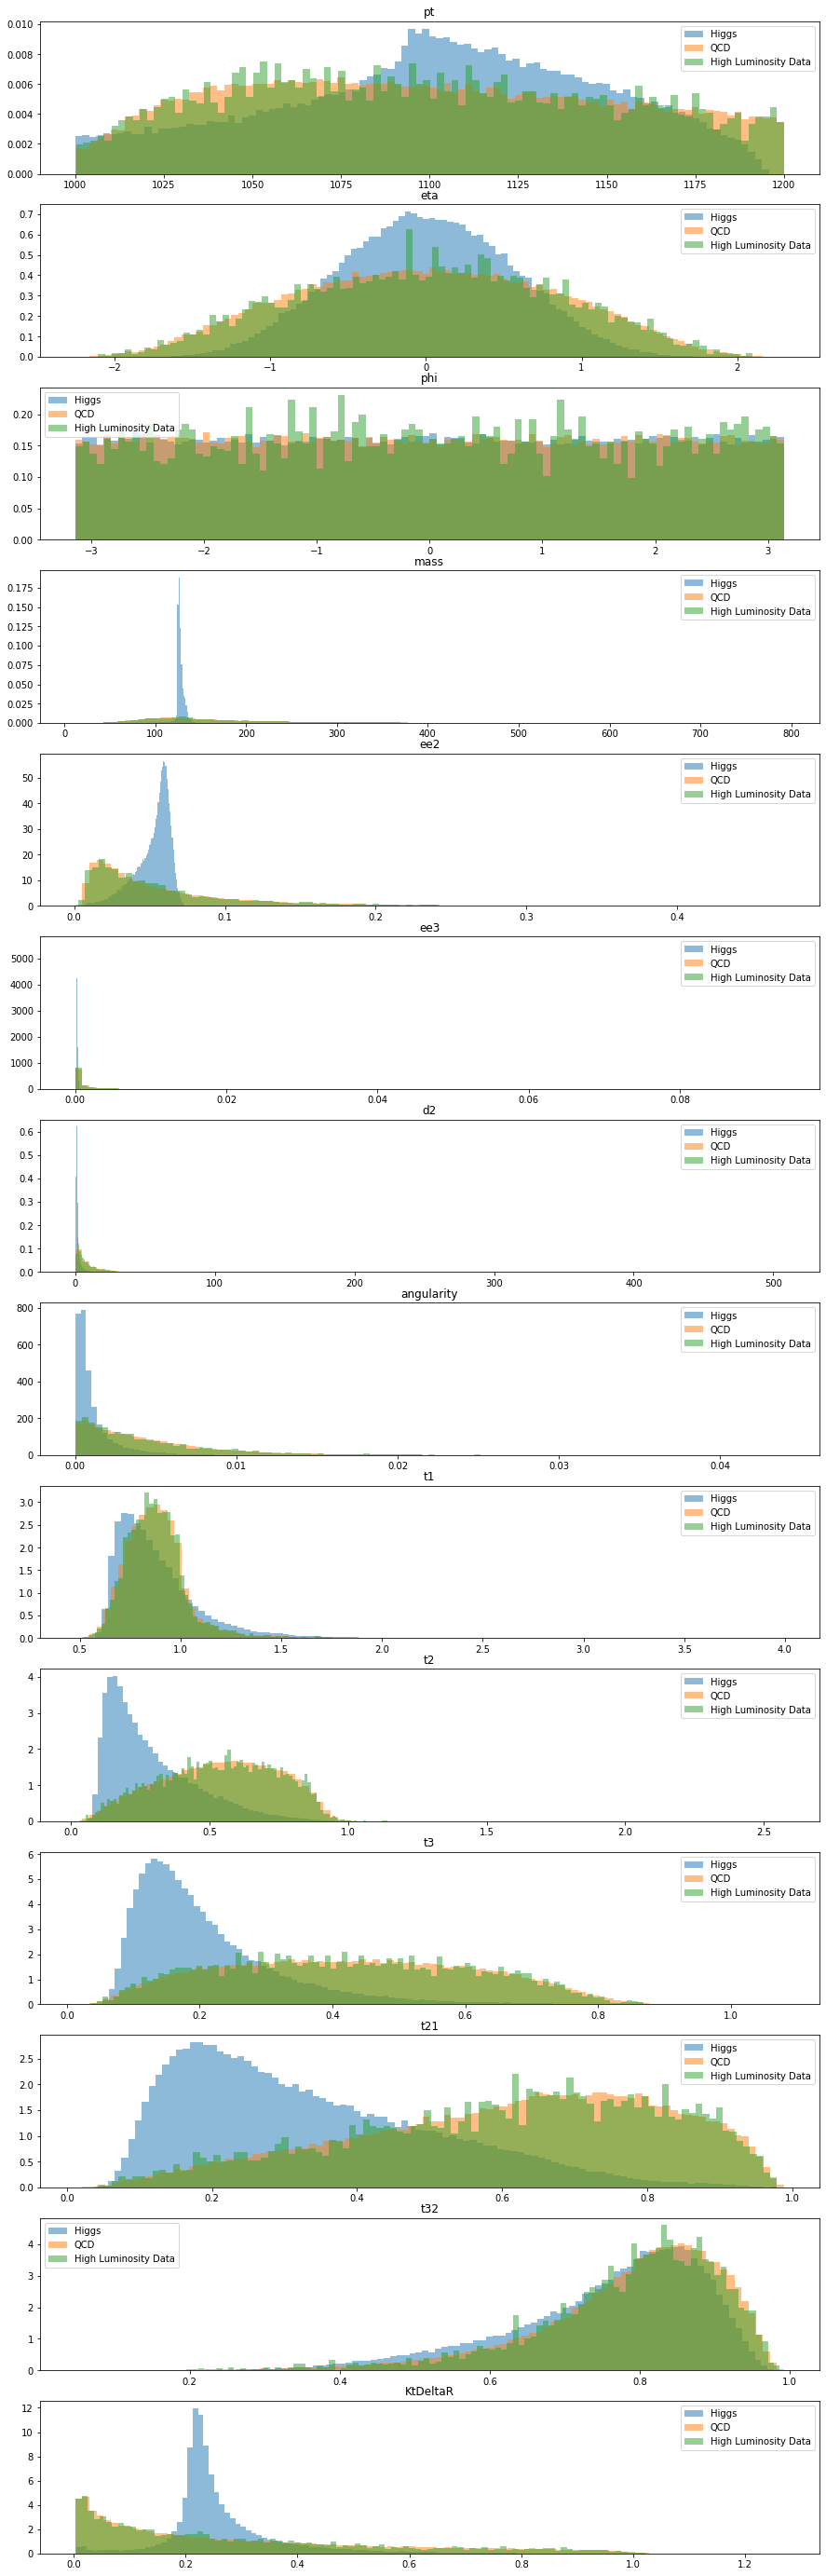

In [47]:
fig, ax_arr = plt.subplots(len(qcd_dict.keys()),1, figsize=(15,50))
index = 0
for key in qcd_dict.keys():
    ax_arr[index].hist(higgs_dict.get(key), bins=100, density=True, alpha = 0.5, label='Higgs')
    ax_arr[index].hist(qcd_dict.get(key), bins=100, density=True, alpha = 0.5, label='QCD')
    ax_arr[index].hist(high.get(key), bins=100, density=True, alpha = 0.5, label='High Luminosity Data')
    ax_arr[index].set_title(key)
    ax_arr[index].legend()
    index += 1

The above are stacked histograms of the higgs data set (light blue), the qcd data set (orange) and the experimental high luminosity data set (green). This is without any event selection.

Now using our data cut to perform our event selection,

In [37]:
high_mask = high.mass.between(best_cut_mass[0],best_cut_mass[1]) & high.d2.between(best_cut_d2[0],best_cut_d2[1])
higgs_mask = higgs_dict.d2.between(best_cut_d2[0],best_cut_d2[1]) & higgs_dict.mass.between(best_cut_mass[0], best_cut_mass[1])
qcd_mask = qcd_dict.d2.between(best_cut_d2[0],best_cut_d2[1]) & qcd_dict.mass.between(best_cut_mass[0], best_cut_mass[1])

N_qcd = len(qcd_dict[qcd_mask == 1])/100000*2000

high_events = len(high[high_mask == 1])

print(f'Selected experiment events: {high_events:.0f}')
print(f'N_QCD in best cut range: {N_qcd:.0f}')
obs_significance = stats.norm.isf(stats.poisson.sf(high_events, N_qcd))
print(f'Observed significance: {obs_significance:.2f}')

Selected experiment events: 67
N_QCD in best cut range: 1
Observed significance: 20.39


There were 67 observed events and 1 expected QCD particle in our experimental data after optimal event selection. This gives an observed significance of 20.4 sigma when calculated using poisson statistics based on our null hypothesis. The 20.4 sigma result is considerably less than 25.8 sigma expected significance as in the training sample but still absolutely enough to claim discovery and refute the null hypothesis that the Higgs boson does not exist.

Below, plots of the remaining data after optimal event selection.

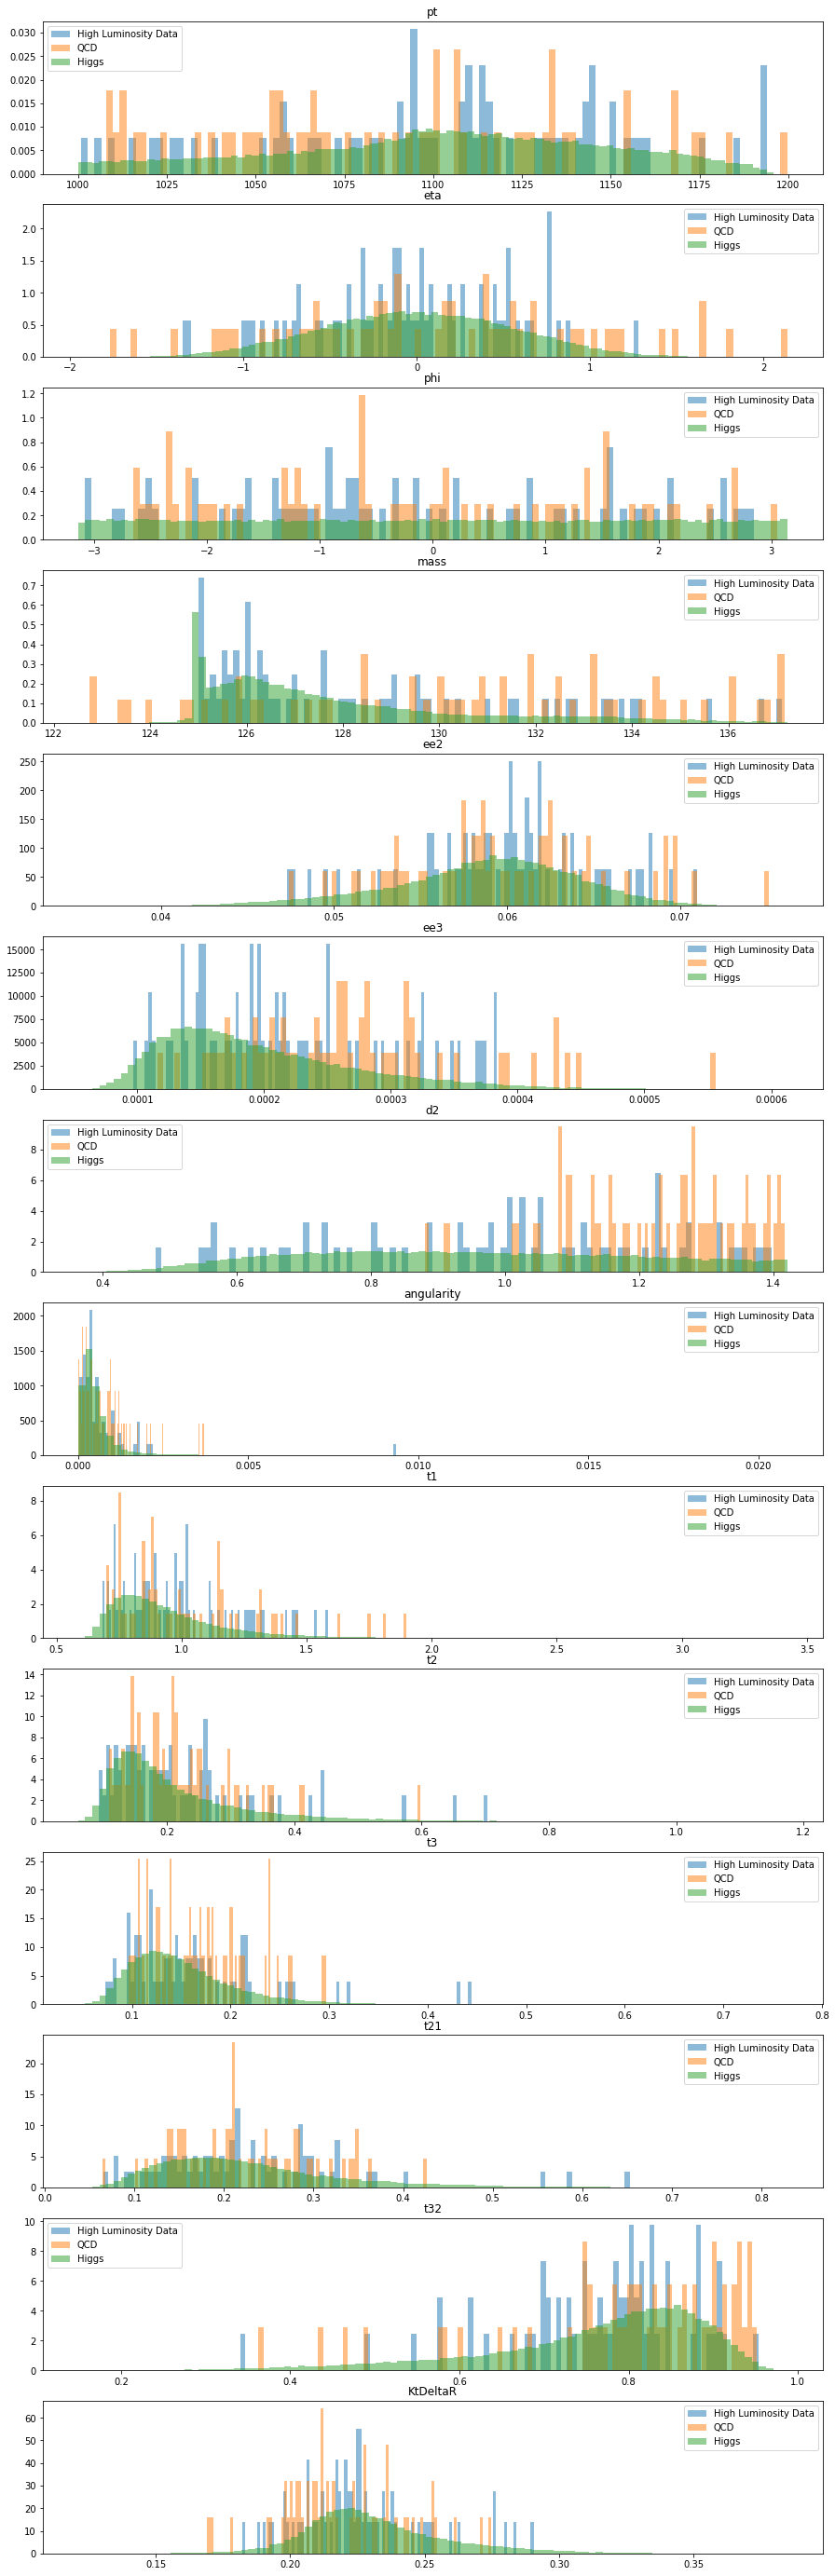

In [38]:
high_select = high[high_mask==1]
qcd_select = qcd_dict[qcd_mask==1]
higgs_select = higgs_dict[higgs_mask==1]

fig, ax_arr = plt.subplots(len(qcd_dict.keys()),1, figsize=(15,50))
keys = qcd_dict.keys()
index=0
for key in keys:
    ax_arr[index].hist(high_select.get(key), bins=100, density=True, alpha = 0.5, label='High Luminosity Data')
    ax_arr[index].hist(qcd_select.get(key), bins=100, density=True, alpha=0.5, label='QCD')
    ax_arr[index].hist(higgs_select.get(key), bins=100, density=True, alpha = 0.5, label='Higgs')
    ax_arr[index].legend()
    ax_arr[index].set_title(key)
    index = index+1

These stacked histograms represent the higgs training set in blue and the observed higgs set chosen by the classifier in orange (Optimal event selection).

#### 3.2: Low Luminosity Data

In [39]:
low = pd.read_hdf('data_lowLumi_pt_1000_1200.h5')
print(f'Total experiment events: {len(low.mass)}')

Total experiment events: 442


In [40]:
N_higgs = len(low.mass)/len(higgs_dict.mass)*Exp_higgs
N_qcd = len(low.mass)/len(qcd_dict.mass)*Exp_qcd
print(f'N_Higgs scaled: {N_higgs:.0f}')
print(f'N_QCD scaled: {N_qcd:.0f}')

N_Higgs scaled: 0
N_QCD scaled: 9


With the expected yield scaled down to the experiment size, we get $N_{QCD}=9$ and $N_{Higgs}=0$.

Below, plots without any event selection.

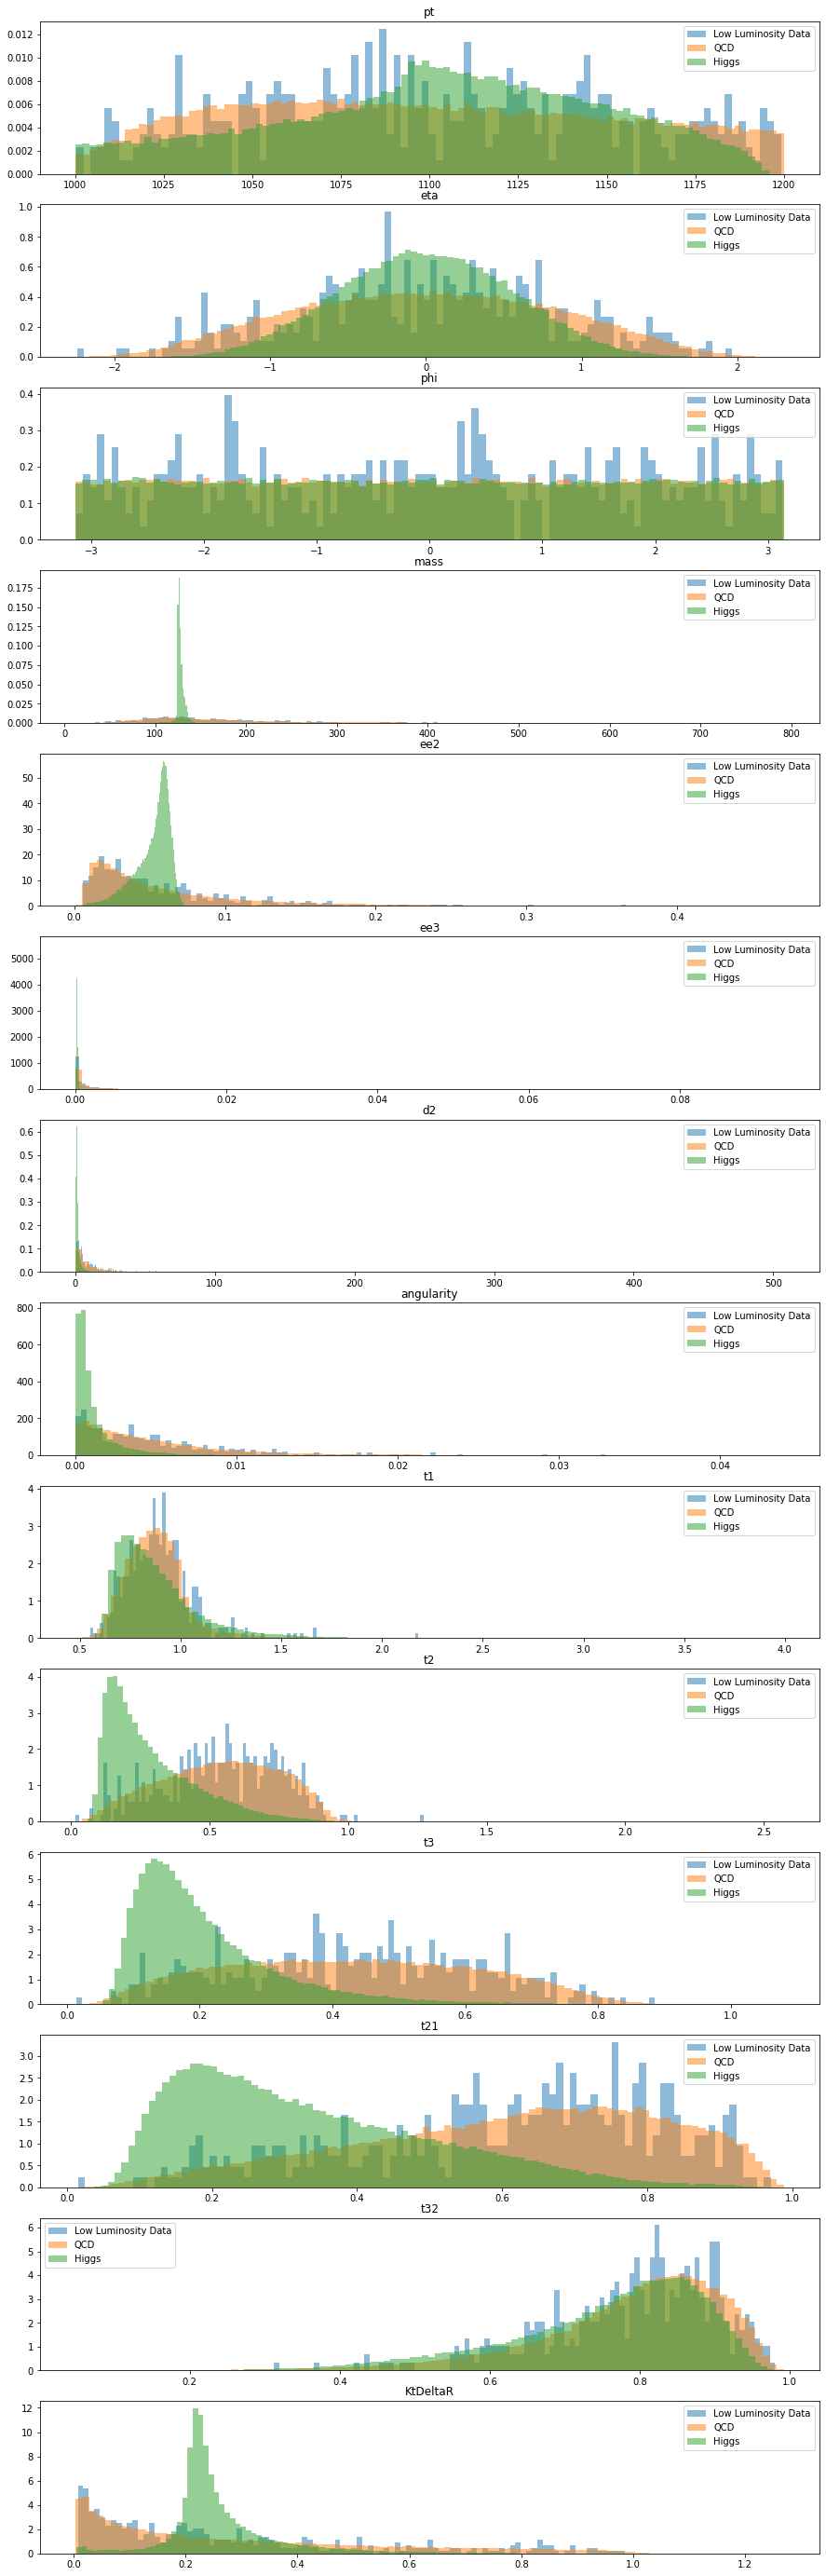

In [41]:
fig, ax_arr = plt.subplots(len(qcd_dict.keys()),1, figsize=(15,50))
keys = qcd_dict.keys()
index=0
for key in keys:
    ax_arr[index].hist(low.get(key), bins=100, density=True, alpha = 0.5, label='Low Luminosity Data')
    ax_arr[index].hist(qcd_dict.get(key), bins=100, density=True, alpha=0.5, label='QCD')
    ax_arr[index].hist(higgs_dict.get(key), bins=100, density=True, alpha = 0.5, label='Higgs')
    ax_arr[index].legend()
    ax_arr[index].set_title(key)
    index = index+1

In [42]:
low_mask = low.mass.between(best_cut_mass[0],best_cut_mass[1]) & low.d2.between(best_cut_d2[0],best_cut_d2[1])
higgs_mask = higgs_dict.d2.between(best_cut_d2[0],best_cut_d2[1]) & higgs_dict.mass.between(best_cut_mass[0], best_cut_mass[1])
qcd_mask = qcd_dict.d2.between(best_cut_d2[0],best_cut_d2[1]) & qcd_dict.mass.between(best_cut_mass[0], best_cut_mass[1])

N_qcd = len(qcd_dict[qcd_mask == 1])/100000*2000
low_events = len(low[low_mask == 1])

print(f'Selected experiment events: {low_events:.0f}')
print(f'N_QCD in best cut range: {N_qcd:.0f}')
obs_significance = stats.norm.isf(stats.poisson.sf(low_events, N_qcd))
print(f'Observed significance: {obs_significance:.2f}')

Selected experiment events: 8
N_QCD in best cut range: 1
Observed significance: 4.45


Our observed significance is 4.45 sigma, which is much lower than the expected 25.8 sigma from the data cut method.

Below, a plot of the experimental data after optimal event selection.

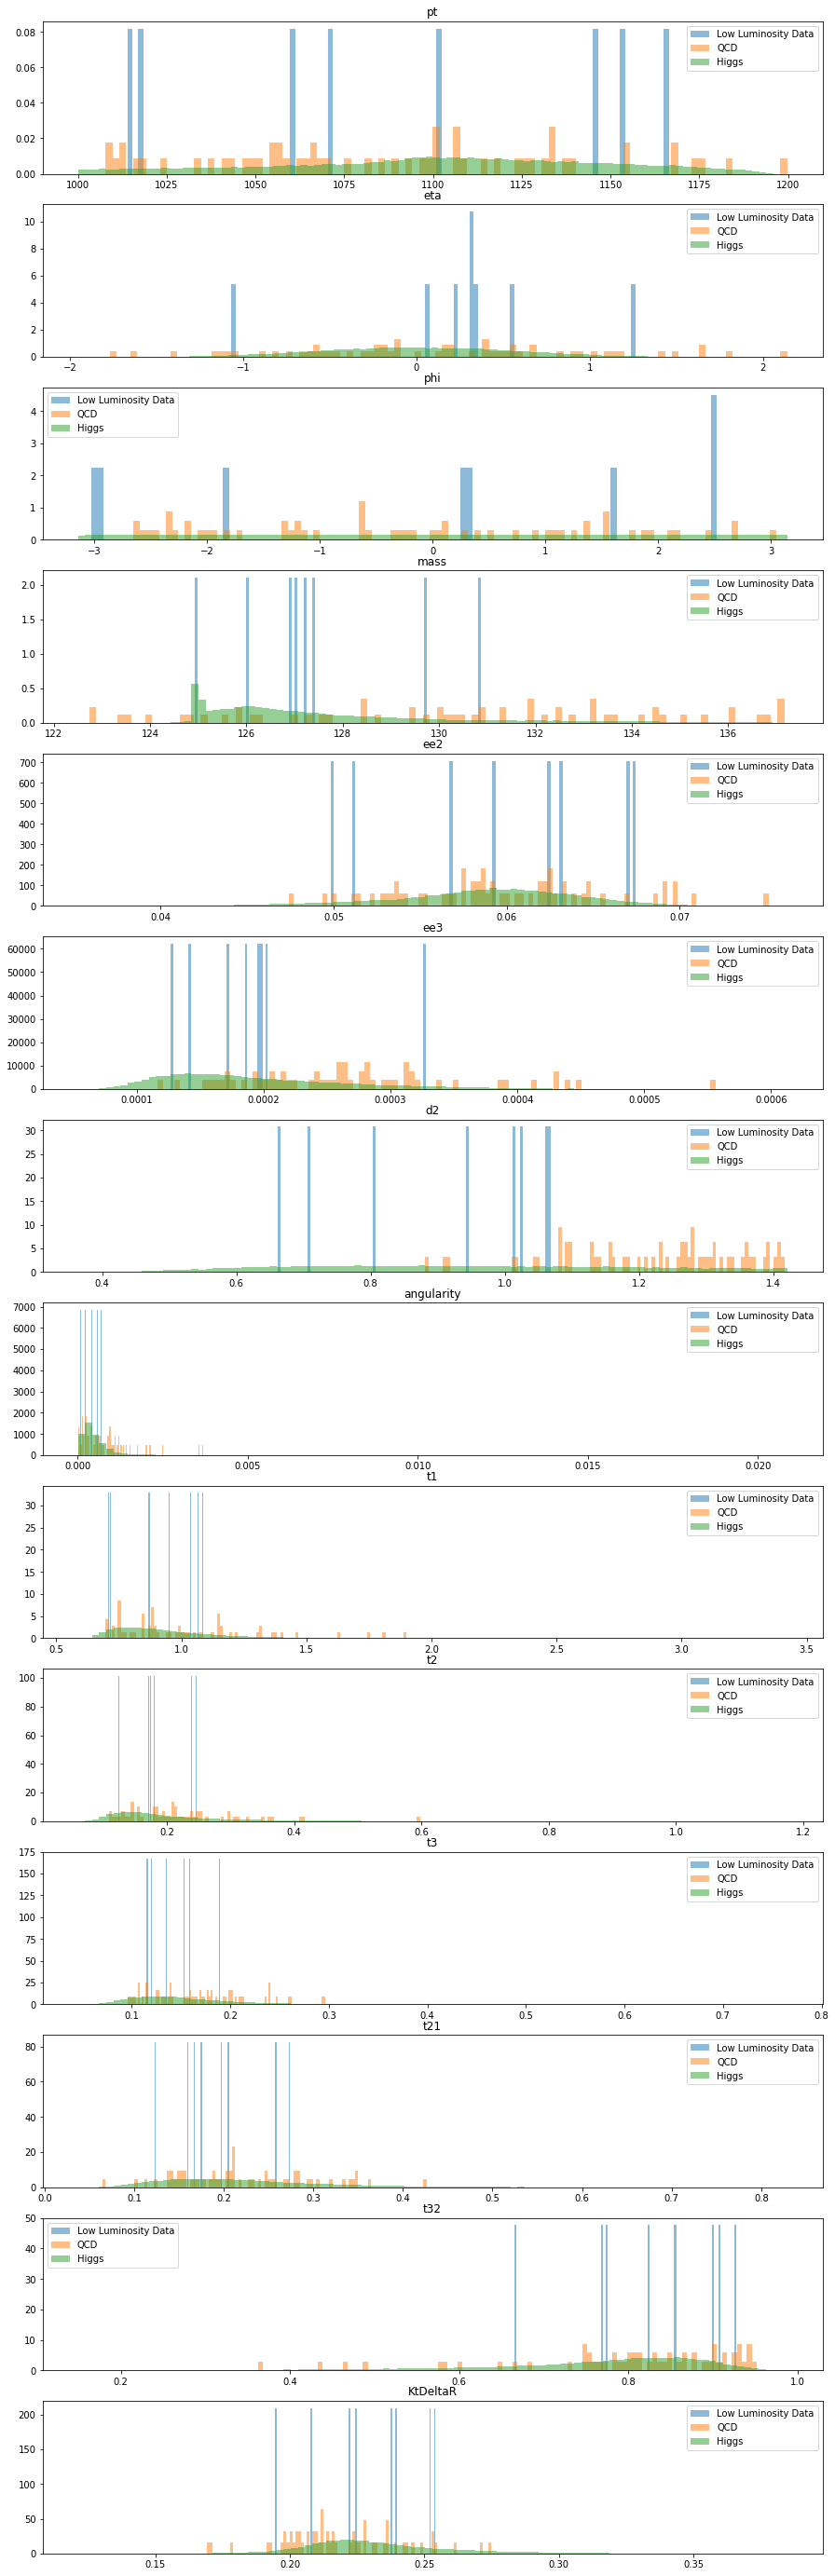

In [43]:
low_select = low[low_mask==1]
qcd_select = qcd_dict[qcd_mask==1]
higgs_select = higgs_dict[higgs_mask==1]

fig, ax_arr = plt.subplots(len(qcd_dict.keys()),1, figsize=(15,50))
keys = qcd_dict.keys()
index=0
for key in keys:
    ax_arr[index].hist(low_select.get(key), bins=100, density=True, alpha = 0.5, label='Low Luminosity Data')
    ax_arr[index].hist(qcd_select.get(key), bins=100, density=True, alpha=0.5, label='QCD')
    ax_arr[index].hist(higgs_select.get(key), bins=100, density=True, alpha = 0.5, label='Higgs')
    ax_arr[index].legend()
    ax_arr[index].set_title(key)
    index = index+1

Evaluating the expected 95% confidence interval on the low luminosity data significance,

In [44]:
higgs_mask = higgs_dict.d2.between(best_cut_d2[0],best_cut_d2[1]) & higgs_dict.mass.between(best_cut_mass[0], best_cut_mass[1])
qcd_mask = qcd_dict.d2.between(best_cut_d2[0],best_cut_d2[1]) & qcd_dict.mass.between(best_cut_mass[0], best_cut_mass[1])
N_higgs = 50*len(higgs_dict.mass[higgs_mask])/size
N_qcd = 2000*len(qcd_dict.mass[qcd_mask])/size
expected_sig = N_higgs / math.sqrt(N_qcd)
upper_sig = (N_higgs + 2*math.sqrt(N_qcd))/math.sqrt(N_qcd)
lower_sig = (N_higgs - 2*math.sqrt(N_qcd))/math.sqrt(N_qcd)
print(f"Expected:  {expected_sig:.2f}")
print(f"Expected 95% condicence level upper limit:  {upper_sig:.2f}")
print(f"Expected 95% condicence level lower limit:  {lower_sig:.2f}")

Expected:  25.84
Expected 95% condicence level upper limit:  27.84
Expected 95% condicence level lower limit:  23.84


In [48]:
uncertainty = (N_higgs + 3*math.sqrt(N_qcd))/math.sqrt(N_qcd) - (N_higgs + 2*math.sqrt(N_qcd))/math.sqrt(N_qcd)
print(f"one sigma uncertainty of expected 95% confidence upper limit: +/-{uncertainty:.2f} sigma")

one sigma uncertainty of expected 95% confidence upper limit: +/-1.00 sigma


The 95% confidence level upper limit is ~30 sigma using our analytic formula from before, but adding the standard deviation (square root of the average for a poisson distribution) multiplied by two to $N_{Higgs}$ to reach the 95% upper bound. Using poisson statistics to calculate the expected significance comes to around 12, which is far different than our analytic formula provides for the significance after event selection. Using poisson statistics to calculate, the upper limit is around 12.6 sigma.

In [46]:
upper = stats.norm.isf(stats.poisson.sf(low_events+N_qcd+2*math.sqrt(N_qcd), N_qcd))
print('Observed 95% confidence level upper limit: ', upper)

Observed 95% confidence level upper limit:  5.726105199676746


The observed 95% confidence level upper limit for the low luminosity data is 5.3 sigma.